Journalism data from rebuild local news
Vote data from Harvard Dataverse https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ 
Population data from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/WLS5GF 

In [9]:
# load the data as pandas DataFrames
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the county news data and vote data
news_data = pd.read_excel('news.xlsx', sheet_name='county data')
vote_data = pd.read_csv('votes.csv')

LJE_column = "Metro-adjusted journalists per population, or the final LJE"

error: Expression [9]:2:8: unable to locate module 'pandas'
import pandas as pd
       ^
error: Expression [9]:3:8: unable to locate module 'numpy'
import numpy as np
       ^
error: Expression [9]:4:8: unable to locate module 'matplotlib'
import matplotlib.pyplot as plt
       ^
error: Expression [9]:4:19: 
import matplotlib.pyplot as plt
                  ^
error: Expression [9]:5:8: unable to locate module 'seaborn'
import seaborn as sns
       ^


expression failed to parse (no further compiler diagnostics)

In [ ]:
# align the county fips between the datasets
news_data['CountyFIPS'] = news_data['CountyFIPS'].astype(str).str.zfill(5)
vote_data['county_fips'] = vote_data['county_fips'].astype(str).str.zfill(5)

news_fips = set(news_data['CountyFIPS'])
vote_fips = set(vote_data['county_fips'])

# find and display the counties in one but not both datasets
missing_in_news = news_fips - vote_fips
missing_in_votes = vote_fips - news_fips
print(f"Counties in news data but not in vote data: {len(missing_in_news)} {list(missing_in_news)}")
print(f"Counties in vote data but not in news data: {len(missing_in_votes)} {list(missing_in_votes)}")

# TODO come back to this and address the mis-matched counties
# this is also currently ALL fips that appear at any time in the votes, not gaurenteed to be 2024
# for example, vote data has "District 04" for alaska, news has county names
# limiting the vote data to just 2024 does not change the number of differing counties
# for now, only use the counties that are in both datasets
common_fips = news_fips.intersection(vote_fips)
news_data = news_data[news_data['CountyFIPS'].isin(common_fips)]
vote_data = vote_data[vote_data['county_fips'].isin(common_fips)]


Counties in news data but not in vote data: 26 ['02164', '02290', '02090', '02110', '02188', '15005', '02050', '02122', '02198', '02105', '02060', '02150', '02220', '02240', '02282', '02195', '02130', '02100', '02170', '02185', '02180', '02158', '02230', '02070', '02275', '02068']
Counties in vote data but not in news data: 87 ['4400751760', '4400722960', '4400935380', '02038', '4400570880', '4400549960', '4400950500', '02034', '4400105140', '02007', '4400759000', '4400378440', '02022', '4400948340', '02040', '4400542400', '02018', '02005', '02002', '02006', '02028', '4400752480', '4400951580', '4400719180', '02031', '4400545460', '02008', '13203', '02019', '4400925300', '4400764220', '13041', '02099', '02024', '02021', '04029', '4400109280', '4400377720', '02029', '02033', '4400961160', '02023', '4400318640', '02014', '51515', '02001', '02009', '4400711800', '02025', '4400730340', '02010', '02037', '4400977000', '02017', '02027', '36000', '4400557880', '4400737720', '4400322240', '440

In [ ]:
# create a DataFrame of the 2024 vote data ['FIPS', 'LJE', 'Total Votes', 'Libertarian Votes', 'Republican Votes', 'Democrat Votes', 'Other Votes']
vote_data_2020 = vote_data[vote_data['year'] == 2024]
unique_parties = vote_data_2020['party'].unique()

data = pd.DataFrame(columns=['FIPS', 'LJE', 'Total Votes', 'Libertarian Votes', 'Republican Votes', 'Democrat Votes', 'Other Votes'])

common_fips_2024 = set(vote_data_2020['county_fips'])
for county_fip in common_fips_2024:
  LJE = news_data[news_data['CountyFIPS'] == county_fip][LJE_column]
  if LJE.empty:
    raise ValueError(f"No LJE data found for county FIPS: {county_fip}")
  
  if county_fip not in vote_data_2020['county_fips'].values:
    raise ValueError(f"County FIPS {county_fip} not found in 2024 vote data")
  
  county_vote_data = vote_data_2020[vote_data_2020['county_fips'] == county_fip]
  total_votes = county_vote_data['totalvotes'].iloc[0]
  party_votes = {
      party: county_vote_data.loc[county_vote_data['party'] == party, 'candidatevotes'].iloc[0]
      if not county_vote_data.loc[county_vote_data['party'] == party, 'candidatevotes'].empty else 0
      for party in ["LIBERTARIAN", "REPUBLICAN", "DEMOCRAT", "OTHER"]
  }
  libertarian_votes = party_votes["LIBERTARIAN"]
  republican_votes = party_votes["REPUBLICAN"]
  democrat_votes = party_votes["DEMOCRAT"]
  other_votes = party_votes["OTHER"]

  data.loc[len(data)] = {
      'FIPS': county_fip,
      'LJE': LJE.iloc[0],
      'Total Votes': total_votes,
      'Libertarian Votes': libertarian_votes,
      'Republican Votes': republican_votes,
      'Democrat Votes': democrat_votes,
      'Other Votes': other_votes
  }

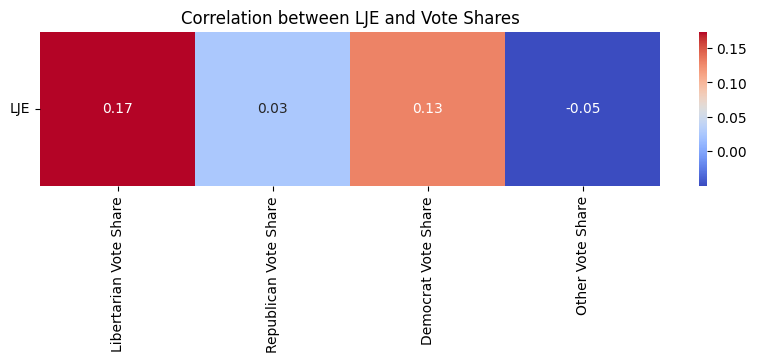

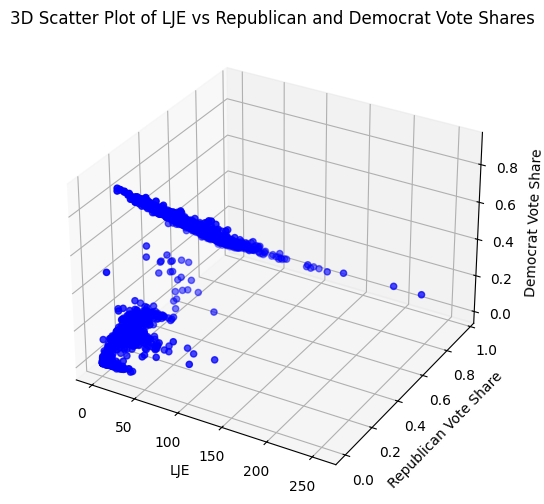

In [ ]:
# does the LJE correlate with the percentage of votes for each party?
data['Libertarian Vote Share'] = data['Libertarian Votes'] / data['Total Votes']
data['Republican Vote Share'] = data['Republican Votes'] / data['Total Votes']
data['Democrat Vote Share'] = data['Democrat Votes'] / data['Total Votes']
data['Other Vote Share'] = data['Other Votes'] / data['Total Votes']

pd_correlation = data[['Libertarian Vote Share', 'Republican Vote Share', 'Democrat Vote Share', 'Other Vote Share']].corrwith(data['LJE'])

plt.figure(figsize=(10, 2))
sns.heatmap(pd_correlation.to_frame().T, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between LJE and Vote Shares')
plt.yticks([0.5], ['LJE'], rotation=0)
plt.show()

# also plot 3-d graph of LJE vs Republican Vote Share vs Democrat Vote Share
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['LJE'], data['Republican Vote Share'], data['Democrat Vote Share'], c='b', marker='o')
ax.set_xlabel('LJE')
ax.set_ylabel('Republican Vote Share')
ax.set_zlabel('Democrat Vote Share')
ax.set_title('3D Scatter Plot of LJE vs Republican and Democrat Vote Shares')
plt.show()

In [ ]:
# can we use machine learning to predict the vote shares based on LJE?
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

features = ['LJE']
targets = [
    'Libertarian Vote Share',
    'Republican Vote Share',
    'Democrat Vote Share',
    'Other Vote Share'
]

X = data[features]
y = data[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

for i, col in enumerate(targets):
    rmse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{col}: RMSE = {rmse:.4f}, R² = {r2:.4f}")



Libertarian Vote Share: RMSE = 0.0000, R² = 0.0451
Republican Vote Share: RMSE = 0.0749, R² = -0.0021
Democrat Vote Share: RMSE = 0.0330, R² = 0.0189
Other Vote Share: RMSE = 0.0146, R² = -0.0087


In [ ]:
# look at how the number of journalists affects the total number of votes
# use census data to get the population of each county for the voting years

# start by getting the population of each county in year 2000
population_data = pd.read_csv('populations.csv') 

vote_data_2000 = vote_data[vote_data['year'] == 2000]
vote_data_2020 = vote_data[vote_data['year'] == 2020]

# in 2024 did counties with more journalists have better total vote turnout per 100k people?
votes_per_100k = pd.DataFrame(columns=['Year', 'FIPS', 'LJE', 'Population', 'TotalVotes', 'VotesPer100k'])

# Ensure all FIPS codes are strings and zero-padded to 5 characters
news_fips = set(news_data['CountyFIPS'].astype(str).str.replace(',', '').str.zfill(5))
vote_fips_2000 = set(vote_data_2000['county_fips'].astype(str).str.zfill(5))
vote_fips_2020 = set(vote_data_2020['county_fips'].astype(str).str.zfill(5))
population_fips = set(population_data['cty_fips'].astype(str).str.zfill(5))

common_fips = news_fips & vote_fips_2000 & vote_fips_2020 & population_fips

# TODO only 3038 common counties between all datasets and years, I could come back to this

for year in [2000, 2020]:
    for fip in common_fips:
      if year == 2000:
          LJE = 40
          population_row = population_data.loc[population_data['cty_fips'] == int(fip)]
          if population_row.empty:
              raise ValueError(f"No population data found for county FIPS: {fip}")
          population = population_row['pop_2000'].values[0]
          total_votes = vote_data_2000.loc[vote_data_2000['county_fips'] == fip, 'totalvotes'].values[0]
      elif year == 2020:
          LJE = news_data.loc[news_data['CountyFIPS'] == fip, LJE_column].values[0]
          population = news_data.loc[news_data['CountyFIPS'] == fip, 'Population'].values[0]
          total_votes = vote_data_2020.loc[vote_data_2020['county_fips'] == fip, 'totalvotes'].values[0]

      votes_per_100k_value = (total_votes / population) * 100000 if population > 0 else 0

      votes_per_100k.loc[len(votes_per_100k)] = {
          'Year': year,
          'FIPS': fip,
          'LJE': LJE,
          'Population': population,
          'TotalVotes': total_votes,
          'VotesPer100k': votes_per_100k_value
      }

In [ ]:
# print(votes_per_100k.describe())
# print(votes_per_100k.head())
# print(votes_per_100k.tail())


# TODO 477 / 6076 rows have counties with > more votes than people
# this is another thing where I would need to go in and check the data manually
# 475 / 477 of these are from 2024 data, bc I am using the news data for population?
# list all rows that have more votes than people
print("Number of counties with more votes than population:", len(votes_per_100k[votes_per_100k['TotalVotes'] > votes_per_100k['Population']]))
print(votes_per_100k[votes_per_100k['TotalVotes'] > votes_per_100k['Population']])

# for now, we will only keep the rows where the total votes are less than or equal to the population
votes_per_100k = votes_per_100k[votes_per_100k['TotalVotes'] <= votes_per_100k['Population']]

print("="*25)
duplicates = vote_data_2020.groupby('county_fips')['totalvotes'].nunique()
print(duplicates[duplicates > 1])


Number of counties with more votes than population: 5
      Year   FIPS        LJE  Population  TotalVotes   VotesPer100k
1530  2000  48301  40.000000          67         156  232835.820896
2806  2000  02013  40.000000        2697        7943  294512.421209
3358  2020  02016  36.814061        5160        8118  157325.581395
4643  2020  48301   0.022817          43          66  153488.372093
5919  2020  02013  15.408039        3461        7713  222854.666281
Series([], Name: totalvotes, dtype: int64)


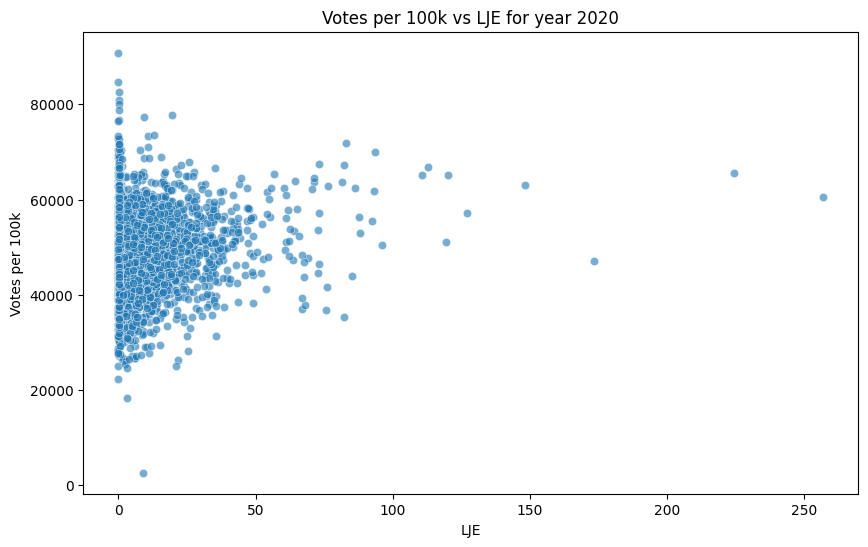

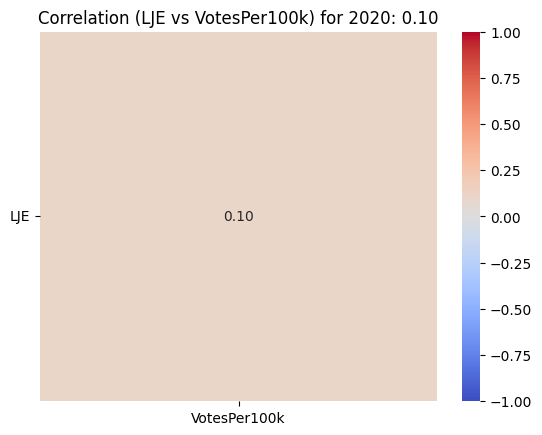

In [ ]:
# visualize and explore how LJE affects the total votes per 100k people in 2024

# first just graph the votes per 100k against LJE for 2024
plt.figure(figsize=(10, 6))
sns.scatterplot(data=votes_per_100k.loc[votes_per_100k['Year'] == 2020], x='LJE', y='VotesPer100k', alpha=0.6)
plt.title('Votes per 100k vs LJE for year 2020')
plt.xlabel('LJE')
plt.ylabel('Votes per 100k')
plt.show()

# are LJE and VotesPer100k correlated for 2020?
correlation_2020 = votes_per_100k.loc[votes_per_100k['Year'] == 2020, ['LJE', 'VotesPer100k']].corr().loc['LJE', 'VotesPer100k']
sns.heatmap(
  votes_per_100k.loc[votes_per_100k['Year'] == 2020, ['LJE', 'VotesPer100k']].corr().loc[['LJE'], ['VotesPer100k']],
  annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, fmt='.2f'
)
plt.title(f'Correlation (LJE vs VotesPer100k) for 2020: {correlation_2020:.2f}')
plt.yticks([0.5], ['LJE'], rotation=0)
plt.show()

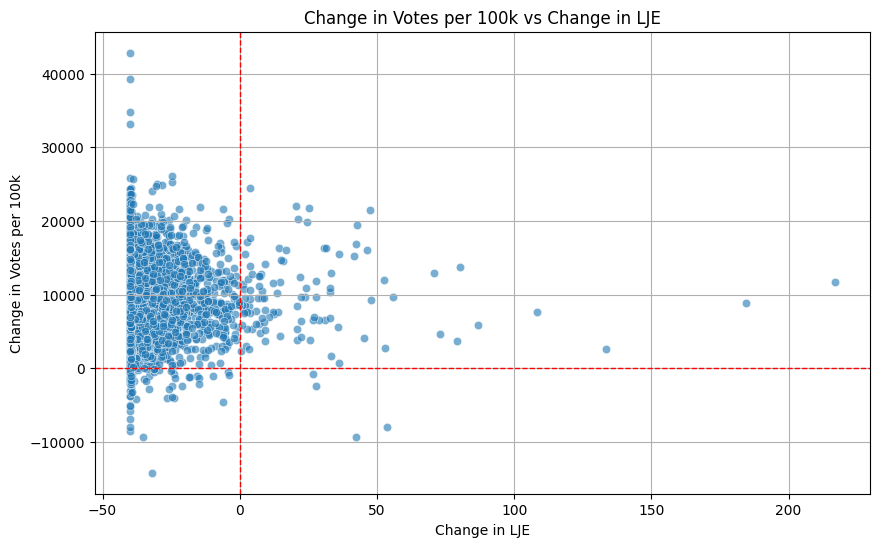

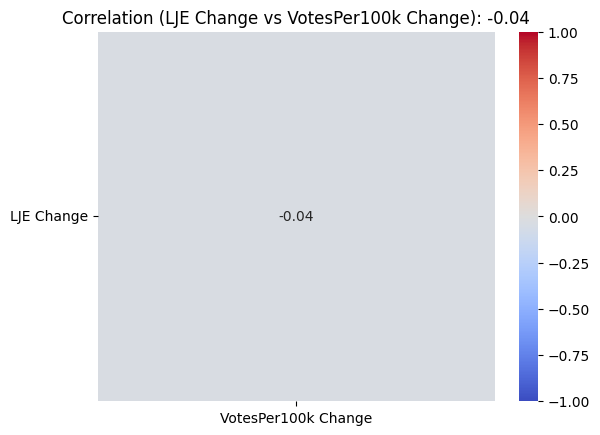

In [ ]:
# does the change in each county's LJE from 2000 to 2024 correlate with the change in votes per 100k?
votes_per_100k['LJE Change'] = votes_per_100k.groupby('FIPS')['LJE'].diff()
votes_per_100k['VotesPer100k Change'] = votes_per_100k.groupby('FIPS')['VotesPer100k'].diff()

# plot the change in LJE vs change in VotesPer100k
plt.figure(figsize=(10, 6))
sns.scatterplot(data=votes_per_100k, x='LJE Change', y='VotesPer100k Change', alpha=0.6)
plt.title('Change in Votes per 100k vs Change in LJE')
plt.xlabel('Change in LJE')
plt.ylabel('Change in Votes per 100k')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

correlation_change = votes_per_100k[['LJE Change', 'VotesPer100k Change']].corr().loc['LJE Change', 'VotesPer100k Change']
sns.heatmap(
  votes_per_100k[['LJE Change', 'VotesPer100k Change']].corr().loc[['LJE Change'], ['VotesPer100k Change']],
  annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, fmt='.2f'
)
plt.title(f'Correlation (LJE Change vs VotesPer100k Change): {correlation_change:.2f}')
plt.yticks([0.5], ['LJE Change'], rotation=0)
plt.show()

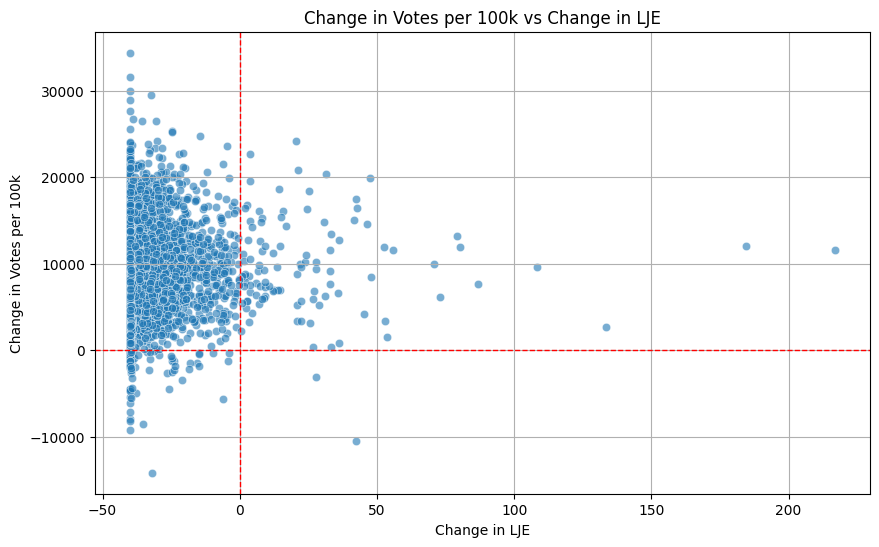

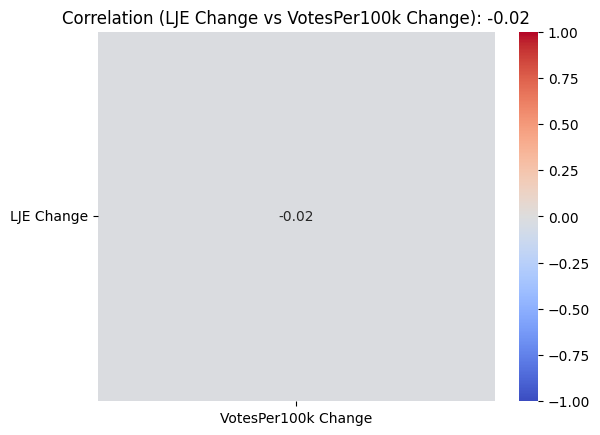

In [ ]:
# because votes per 100k seems to be increasing like crazy
# that is likely because we are pulling 2024 population from the news data
# we will try this again with the 2020 population and vote data, but 2024 LJE data
# because the LJE probably hasnt changed that much in 4 years

population_data = pd.read_csv('populations.csv') 

vote_data_2000 = vote_data[vote_data['year'] == 2000]
vote_data_2020 = vote_data[vote_data['year'] == 2020]

# in 2024 did counties with more journalists have better total vote turnout per 100k people?
votes_per_100k = pd.DataFrame(columns=['Year', 'FIPS', 'LJE', 'Population', 'TotalVotes', 'VotesPer100k'])

# Ensure all FIPS codes are strings and zero-padded to 5 characters
news_fips = set(news_data['CountyFIPS'].astype(str).str.replace(',', '').str.zfill(5))
vote_fips_2000 = set(vote_data_2000['county_fips'].astype(str).str.zfill(5))
vote_fips_2020 = set(vote_data_2020['county_fips'].astype(str).str.zfill(5))
population_fips = set(population_data['cty_fips'].astype(str).str.zfill(5))

common_fips = news_fips & vote_fips_2000 & vote_fips_2020 & population_fips

# TODO only 3038 common counties between all datasets and years, I could come back to this

for year in [2000, 2020]:
    for fip in common_fips:
      if fip not in news_data['CountyFIPS'].values:
        raise ValueError(f"County FIPS {fip} not found in news data")
      elif fip not in vote_data_2000['county_fips'].values and year == 2000:
        raise ValueError(f"County FIPS {fip} not found in 2000 vote data")
      elif fip not in vote_data_2020['county_fips'].values and year == 2020:
        raise ValueError(f"County FIPS {fip} not found in 2020 vote data")
      
      if year == 2000:
          LJE = 40
          population_row = population_data.loc[population_data['cty_fips'] == int(fip)]
          if population_row.empty:
              raise ValueError(f"No population data found for county FIPS: {fip}")
          population = population_row['pop_2000'].values[0]
          total_votes = vote_data_2000.loc[vote_data_2000['county_fips'] == fip, 'totalvotes'].values[0]
      elif year == 2020:
          LJE = news_data.loc[news_data['CountyFIPS'] == fip, LJE_column].values[0]
          population_row = population_data.loc[population_data['cty_fips'] == int(fip)]
          if population_row.empty:
              raise ValueError(f"No population data found for county FIPS: {fip}")
          population = population_row['pop_2020'].values[0]
          total_votes = vote_data_2020.loc[vote_data_2020['county_fips'] == fip, 'totalvotes'].values[0]

      votes_per_100k_value = (total_votes / population) * 100000 if population > 0 else 0

      votes_per_100k.loc[len(votes_per_100k)] = {
          'Year': year,
          'FIPS': fip,
          'LJE': LJE,
          'Population': population,
          'TotalVotes': total_votes,
          'VotesPer100k': votes_per_100k_value
      }
      
# TODO why do some counties have more votes than people?
# Still only keeping the rows where the total votes are less than or equal to the population
votes_per_100k = votes_per_100k[votes_per_100k['TotalVotes'] <= votes_per_100k['Population']]

# does the change in each county's LJE from 2000 to 2024 correlate with the change in votes per 100k?
votes_per_100k['LJE Change'] = votes_per_100k.groupby('FIPS')['LJE'].diff()
votes_per_100k['VotesPer100k Change'] = votes_per_100k.groupby('FIPS')['VotesPer100k'].diff()

# plot the change in LJE vs change in VotesPer100k
plt.figure(figsize=(10, 6))
sns.scatterplot(data=votes_per_100k, x='LJE Change', y='VotesPer100k Change', alpha=0.6)
plt.title('Change in Votes per 100k vs Change in LJE')
plt.xlabel('Change in LJE')
plt.ylabel('Change in Votes per 100k')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

correlation_change = votes_per_100k[['LJE Change', 'VotesPer100k Change']].corr().loc['LJE Change', 'VotesPer100k Change']
sns.heatmap(
  votes_per_100k[['LJE Change', 'VotesPer100k Change']].corr().loc[['LJE Change'], ['VotesPer100k Change']],
  annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, fmt='.2f'
)
plt.title(f'Correlation (LJE Change vs VotesPer100k Change): {correlation_change:.2f}')
plt.yticks([0.5], ['LJE Change'], rotation=0)
plt.show()

In [ ]:
import pandas as pd
# because of the funky-ness of the datasets, let's use another dataset and look at state level data
# using state level data from https://www.electproject.org/election-data/voter-turnout-data 

state_data_2000 = pd.read_csv('state_votes_2000.csv')
state_data_2020 = pd.read_csv('state_votes_2020.csv')

# we will assume that the LJE for each state in 2000 is 40
# we will use the LJE from 2024 for the 2020 data "Statewide LJEs per population" column
state_news_data = pd.read_excel('news.xlsx', sheet_name='state data')

print(state_news_data.head())

turnout_and_LJE_by_year = pd.DataFrame(columns=['Year', 'State', 'LJE', 'TurnoutPercent'])

for state in state_news_data['State']:
    if state not in state_data_2000['State'].values or state not in state_data_2020['State'].values:
        print(f"State {state} not found in both 2000 and 2020 vote data")
        continue
    
    LJE_2000 = 40
    LJE_2020 = state_news_data.loc[state_news_data['State'] == state, 'Statewide LJEs per population'].values[0]
    
    turnout_2000 = state_data_2000.loc[state_data_2000['State'] == state, 'TurnoutPercent'].values[0]
    turnout_2020 = state_data_2020.loc[state_data_2020['State'] == state, 'TurnoutPercent'].values[0]
    
    turnout_and_LJE_by_year.loc[len(turnout_and_LJE_by_year)] = {
        'Year': 2000,
        'State': state,
        'LJE': LJE_2000,
        'TurnoutPercent': turnout_2000
    }
    
    turnout_and_LJE_by_year.loc[len(turnout_and_LJE_by_year)] = {
        'Year': 2020,
        'State': state,
        'LJE': LJE_2020,
        'TurnoutPercent': turnout_2020
    }

print(turnout_and_LJE_by_year.head())
print(turnout_and_LJE_by_year.shape())

error: Expression [15]:12:7: use of unknown declaration 'state_news_data'
print(state_news_data.head())
      ^~~~~~~~~~~~~~~
error: Expression [15]:16:14: use of unknown declaration 'state_news_data'
for state in state_news_data['State']:
             ^~~~~~~~~~~~~~~
error: Expression [15]:17:21: use of unknown declaration 'state_data_2000'
    if state not in state_data_2000['State'].values or state not in state_data_2020['State'].values:
                    ^~~~~~~~~~~~~~~
error: Expression [15]:17:100: statements must start at the beginning of a line
    if state not in state_data_2000['State'].values or state not in state_data_2020['State'].values:
                                                                                                   ^


expression failed to parse (no further compiler diagnostics)